<font size="+3"><strong>Linear Regression with Time Series Data</strong></font>

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
#import pymongo as MongoClient
import plotly.express as px
import pytz
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Prepare Data

In [26]:
#client = MongoClient(host="localhost", port=27017)
#db = client["air-quality"]
#nairobi = db["nairobi"]

In [27]:
def wrangle(collection):
    results = collection.find(
        {"metadata.site": 29, "metadata.measurement": "P2"},
        projection={"P2": 1, "timestamp": 1, "_id": 0},
    )
    df = pd.DataFrame(results).set_index("timestamp")

    #localize timezone
    df.index= df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")    
    #Remove outliers
    df = df[df["P2"] < 500]
    #resample to 1Hr window forward fill missing values
    df = df["P2"].resample("1H").mean().fillna(method="ffill").to_frame()
    #Add lag features
    df["P2-L1"] = df["P2"].shift(1)
    #drop NaN rowa
    df.dropna(inplace=True)
    
    return df

In [28]:
df = pd.read_csv("./task3/P2-P2.5-nairobi.txt")

In [29]:
#df.to_csv("./P2-P2.L1-nairobi-2.csv")

In [30]:
#df = pd.DataFrame(df).set_index("timestamp")

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2927 entries, 0 to 2926
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  2927 non-null   object 
 1   P2         2927 non-null   float64
 2   P2-L1      2927 non-null   float64
dtypes: float64(2), object(1)
memory usage: 68.7+ KB


In [32]:
# Check your work
assert any([isinstance(df, pd.DataFrame), isinstance(df, pd.Series)])
assert len(df) <= 32907
#assert isinstance(df.index, pd.DatetimeIndex)

In [33]:
#assert df.index.tzinfo == pytz.timezone("Africa/Nairobi")

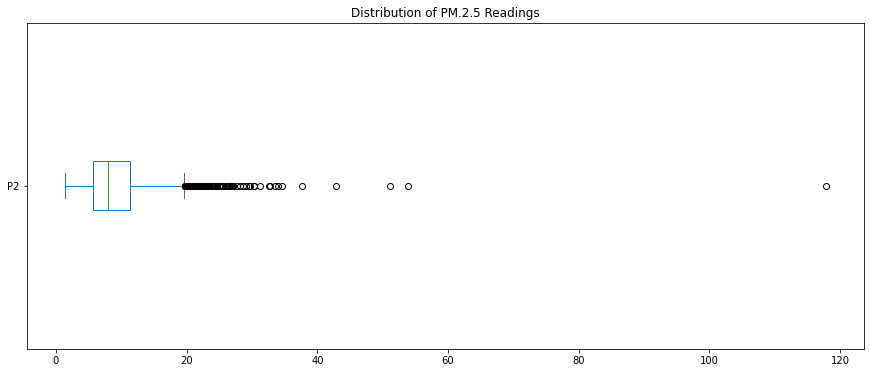

In [34]:
fig, ax = plt.subplots(figsize=(15, 6))
df["P2"].plot(kind="box", vert=False, title= "Distribution of PM.2.5 Readings", ax=ax);

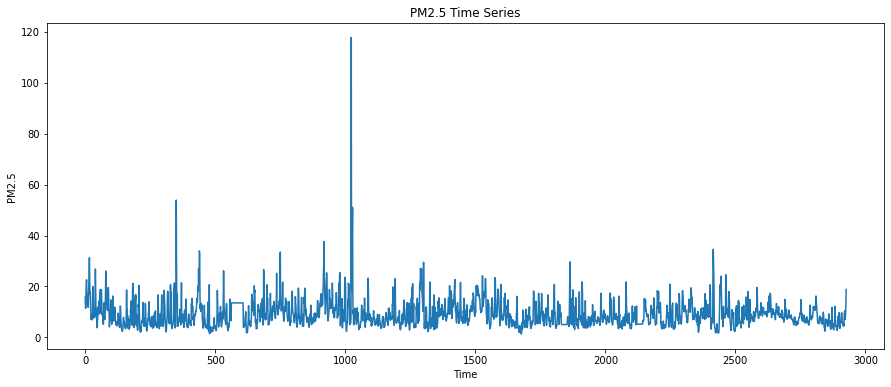

In [35]:
fig, ax = plt.subplots(figsize=(15, 6))
df["P2"].plot(xlabel="Time", ylabel="PM2.5", title="PM2.5 Time Series", ax=ax);

In [36]:
df["P2"].rolling(168).mean().head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: P2, dtype: float64

In [37]:
len(df)

2927

In [38]:
df["P2"].rolling(168).mean().isnull().sum() #this shows the first 167 hours is not recorded , so the plot start after 168hrs

167

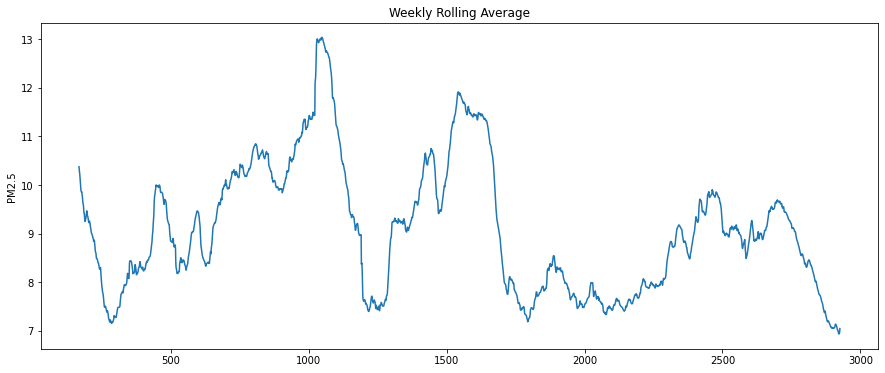

In [39]:
fig, ax = plt.subplots(figsize=(15, 6))
df["P2"].rolling(168).mean().plot(ax=ax,ylabel="PM2.5", title="Weekly Rolling Average");

In [40]:
#df["P2-L1"] = df["P2"].shift(1)
df.dropna().head()

,timestamp,P2,P2-L1
0,2018-09-01 04:00:00+03:00,15.800000,17.541667
1,2018-09-01 05:00:00+03:00,11.420000,15.800000
2,2018-09-01 06:00:00+03:00,11.614167,11.420000
3,2018-09-01 07:00:00+03:00,17.665000,11.614167
4,2018-09-01 08:00:00+03:00,21.016667,17.665000


In [41]:
# Check your work
assert len(df) <= 11686
assert df.shape[1] == 2

AssertionError: 

In [ ]:
df.corr()

,P2,P2-L1
P2,1.000000,0.650679
P2-L1,0.650679,1.000000


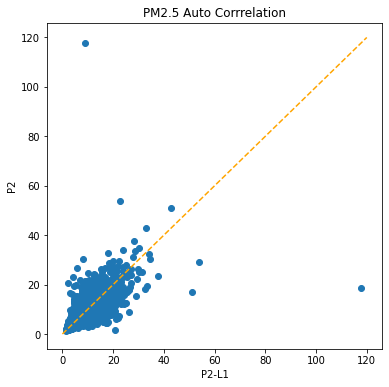

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=df["P2-L1"], y=df["P2"])
ax.plot([0, 120], [0,120], linestyle="--", color="orange")
plt.xlabel("P2-L1")
plt.ylabel("P2")
plt.title("PM2.5 Auto Corrrelation");

In [ ]:
target = "P2"
y = df[target]
X = df.drop(columns=target)

In [ ]:
X.head()

,timestamp,P2-L1
0,2018-09-01 04:00:00+03:00,17.541667
1,2018-09-01 05:00:00+03:00,15.800000
2,2018-09-01 06:00:00+03:00,11.420000
3,2018-09-01 07:00:00+03:00,11.614167
4,2018-09-01 08:00:00+03:00,17.665000


In [44]:
cutoff = int(len(X)*0.8)

X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

In [ ]:
X.iloc[:cutoff]

,timestamp,P2-L1
0,2018-09-01 04:00:00+03:00,17.541667
1,2018-09-01 05:00:00+03:00,15.800000
2,2018-09-01 06:00:00+03:00,11.420000
3,2018-09-01 07:00:00+03:00,11.614167
4,2018-09-01 08:00:00+03:00,17.665000
...,...,...
2336,2018-12-07 12:00:00+03:00,11.117500
2337,2018-12-07 13:00:00+03:00,6.961667
2338,2018-12-07 14:00:00+03:00,6.961667
2339,2018-12-07 15:00:00+03:00,7.129167


In [ ]:
len(X_train) + len(X_test) == len(X)

True

# Build Model
## Baseline
**Task** Calculate the baseline mean absolute error for your model.

In [ ]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
mae_baseline = mean_absolute_error(y_train,y_pred_baseline)

print("Mean P2 Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 9.27
Baseline MAE: 3.89


## Iterate
**Task** Instantiate a [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model named `model`, and fit it to your training data.

In [45]:
model = LinearRegression()
model.fit(X_train, y_train)

**Task:** Calculate the training and test mean absolute error for your model.

In [ ]:
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 2.46
Test MAE: 1.8


# Communicate Results
**Task:** Extract the intercept and coefficient from your `model`. 

In [ ]:
intercept = model.intercept_.round(2)
coefficient = model.coef_.round(2)[0]

print(f"P2 = {intercept} + ({coefficient} * P2-L1)")

P2 = 3.36 + (0.64 * P2-L1)


In [ ]:
df_pred_test = pd.DataFrame(
    {
        "y_test": y_test,
        "y_predict": model.predict(X_test)
    }
)
df_pred_test.head()

,y_test,y_predict
timestamp,,
2018-12-07 17:00:00+03:00,7.070000,8.478927
2018-12-07 18:00:00+03:00,8.968333,7.865485
2018-12-07 19:00:00+03:00,11.630833,9.076421
2018-12-07 20:00:00+03:00,11.525833,10.774814
2018-12-07 21:00:00+03:00,9.533333,10.707836


In [ ]:
fig = px.line(df_pred_test, labels={"value":"P2"})
fig.show();